In [1]:
%load_ext autoreload
%autoreload 2

from multibind.nonequilibrium import rate_matrix
import multibind as mb
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def dG2pKa(dG, pH):
    return pH - dG / np.log(10)

## Equilibrium conditions

In [3]:
pH = 8
Na = 0.1 # 100 mM

input_rates = 'inputs/rates.csv'

c, k, std = rate_matrix(input_rates)

states = c.states.values
free_energies = c.g_mle
g_std_err = c.std_errors

new_graph = c.graph.copy()

for index, data in new_graph.iterrows():
    state1, state2, value, variance, ligand, std = data
    print(state1, state2, value, variance, ligand, std)

    if (state1[-1] == "H" and state2[-1] == "0") or (state1[-1] == "A" and state2[-1] == "0"):
        # backwards proton reaction
        new_graph.at[index, 'state1'] = state2
        new_graph.at[index, 'state2'] = state1
        new_graph.at[index, 'value'] = -value
        
        value = new_graph.value[index]
        state1 = new_graph.state1[index]
        state2 = new_graph.state2[index]
        
    if state1[-1] == "0" and state2[-1] == "H":
        new_graph.at[index, 'ligand'] = "H+"
        new_graph.at[index, 'value'] = dG2pKa(new_graph.value[index], pH)
        new_graph.at[index, 'variance'] = new_graph.variance[index] / np.log(10)**2
    if state1[-1] == "0" and state2[-1] == "A":
        new_graph.at[index, 'ligand'] = "Na+"
        new_graph.at[index, 'value'] = new_graph.value[index] + np.log(Na)
        
new_graph

IFH IF0 -3.283414346005772 0.0403515625 helm 1
IF0 IFNA -1.3862943611198906 0.01140625 helm 1
IFNA OFNA 0.4700036292457356 0.00780625 helm 1
OFNA OF0 0.6931471805599453 0.0325 helm 1
OF0 OFH 3.3141860046725258 0.0144008264462809 helm 1
OFH IFH 0.4700036292457356 0.0200515624999999 helm 1


,state1,state2,value,variance,ligand,standard_state
0,IF0,IFH,6.574031,0.007611,H+,1
1,IF0,IFNA,-3.688879,0.011406,Na+,1
2,IFNA,OFNA,0.470004,0.007806,helm,1
3,OF0,OFNA,-2.995732,0.032500,Na+,1
4,OF0,OFH,6.560667,0.002716,H+,1
5,OFH,IFH,0.470004,0.020052,helm,1


In [4]:
c_equil = mb.Multibind()
c_equil.graph = new_graph
c_equil.states = c.states

scanner = mb.multibind.MultibindScanner(statefile=None, graphfile=None)
scanner.c = c_equil

In [5]:
sod_bound = {'IF0': 'unbound',
             'IFH': 'unbound',
             'IFNA': 'bound',
             'OF0': 'unbound',
             'OFH': 'unbound',
             'OFNA': 'bound',
            }

prot_bound = {'IF0': 'unbound',
              'IFH': 'bound',
              'IFNA': 'unbound',
              'OF0': 'unbound',
              'OFH': 'bound',
              'OFNA': 'unbound',
             }

conf = {'IF0': 'inward',
        'IFH': 'inward',
        'IFNA': 'inward',
        'OF0': 'outward',
        'OFH': 'outward',
        'OFNA': 'outward',
       }

In [6]:
scanner.c.states['conf'] = list(map(lambda x: conf[x[0]], scanner.c.states.values))
scanner.c.states['prot_bound'] = list(map(lambda x: prot_bound[x[0]], scanner.c.states.values))
scanner.c.states['sod_bound'] = list(map(lambda x: sod_bound[x[0]], scanner.c.states.values))

In [7]:
from equil import run

<xarray.DataArray 'free_energy' (state: 6)>
array([ 0.        , -3.3719631 , -4.7832877 , -4.33041436, -3.70858621,
       -0.42600184])
Coordinates:
  * state    (state) object 'IFH' 'IF0' 'IFNA' 'OFNA' 'OF0' 'OFH'
    Na+      float64 0.1
    pH       int64 8
IFH (0.0) --> IF0 (-3.3719631041875946) => -3.3719631041875946 ± 0.1473590402615086
IF0 (-3.3719631041875946) --> IFNA (-4.78328770302331) => -1.4113245988357157 ± 0.13263988193025508
IFNA (-4.78328770302331) --> OFNA (-4.330414358574045) => 0.45287334444926497 ± 0.127848639936592
OFNA (-4.330414358574045) --> OF0 (-3.708586212946359) => 0.6218281456276862 ± 0.13619418989796764
OF0 (-3.708586212946359) --> OFH (-0.4260018405202416) => 3.2825843724261174 ± 0.14390515026863906
OFH (-0.4260018405202416) --> IFH (0.0) => 0.4260018405202416 ± 0.15042093642120827
-1.1102230246251565e-16


<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

<Figure size 216x144 with 0 Axes>

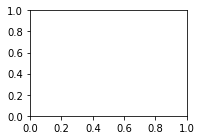

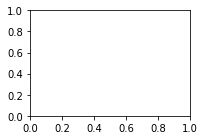

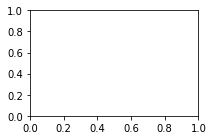

In [8]:
run(scanner);

In [9]:
from transport import transport

['IF0/IFH', 'IF0/IFNA', 'IFNA/OFNA', 'OF0/OFNA', 'OF0/OFH', 'OFH/IFH']
   name     conf prot_bound sod_bound
0   IFH   inward      bound   unbound
1   IF0   inward    unbound   unbound
2  IFNA   inward    unbound     bound
3  OFNA  outward    unbound     bound
4   OF0  outward    unbound   unbound
5   OFH  outward      bound   unbound
  state1 state2     value  variance ligand  standard_state
0    IF0    IFH  6.574031  0.007611     H+               1
1    IF0   IFNA -3.688879  0.011406    Na+               1
2   IFNA   OFNA  0.470004  0.007806   helm               1
3    OF0   OFNA -2.995732  0.032500    Na+               1
4    OF0    OFH  6.560667  0.002716     H+               1
5    OFH    IFH  0.470004  0.020052   helm               1


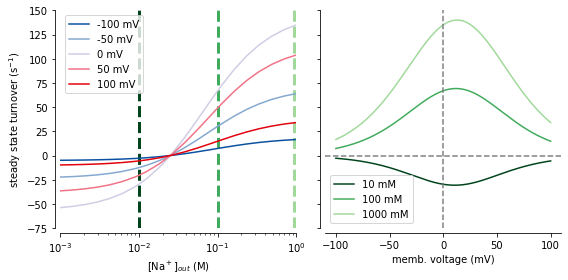

In [12]:
display_voltages = np.array([-0.1, -0.05, 0, 0.05, 0.1])
voltages = np.concatenate([np.linspace(-0.1, 0.1, 1001)[1:-1], display_voltages])
voltages.sort()

fixed = np.array([0.001, 0.01, 0.1, 1])
na_out = np.concatenate([np.logspace(-3, 0, 20)[1:-1], fixed])
na_out.sort()

data = np.zeros((voltages.shape[0], na_out.shape[0]))

G = None

for i, v in enumerate(voltages):
    for j, na in enumerate(na_out):
        flux, drive, connection_labels, pops, Gp = transport(c_equil, k, 10**-pH, Na, **{'c_na_out': na, 'voltage': v})
        data[i, j] = flux
        if i == 30:
            G = Gp

fig, (ax_na, ax_v) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))

ax_na.axvline(1-0.075, linestyle='dashed', color='#a1d99b', lw=3)
ax_na.axvline(0.1, linestyle='dashed', color='#41ab5d', lw=3)
ax_na.axvline(0.01, linestyle='dashed', color='#00441b', lw=3)

ax_na.set_xlabel(r'$[$Na$^+]_{out}$ (M)')
ax_na.set_ylabel(r'steady state turnover (s$^{-1}$)')


    
na_idx001 = np.argwhere(na_out == 0.01)[0][0]
na_idx01 = np.argwhere(na_out == 0.1)[0][0]
na_idx1 = np.argwhere(na_out == 1.0)[0][0]

volt_colors =  ["#0a50a1",
                "#85a8d0",
                "#d0cde5",
                "#f07386",
                "#e1000c",]

for _i, volt in enumerate(display_voltages):
    i = np.argwhere(voltages == volt)[0][0]
    ax_na.semilogx(na_out, data[i, :], color=volt_colors[_i], label=f'{volt*1000:.0f} mV')

ax_v.plot(voltages*1e3, data[:, na_idx001], color='#00441b', label=f'10 mM')
ax_v.plot(voltages*1e3, data[:, na_idx01], color='#41ab5d', label=f'100 mM')
ax_v.plot(voltages*1e3, data[:, na_idx1], color='#a1d99b', label=f'1000 mM')

ax_v.axvline(0, color='gray', linestyle='dashed')
ax_v.axhline(0, color='gray', linestyle='dashed')

ax_v.set_xlabel("memb. voltage (mV)")

sns.despine(ax=ax_v, offset=5)
sns.despine(ax=ax_na, offset=5)

ax_na.set_xlim([0.001, 1])
ax_na.set_ylim([-75, 150])

ax_na.legend(loc='best')
ax_v.legend(loc='best')

outimgdir = Path("img/noneq/")
outimgdir.mkdir(exist_ok=True, parents=True)

plt.tight_layout()
plt.savefig(outimgdir / "transport.pdf")

print(connection_labels)
print(c_equil.states)
print(c_equil.graph)

In [5]:
from itertools import product
import xarray as xr
from tqdm import tqdm

In [18]:
na_in = np.logspace(-3, 0, 10)
na_out = np.logspace(-3, 0, 10)
c_h_in = np.array([10**-(7+i*.2) for i in range(6)])
c_h_out = np.array([10**-(7+i*.2) for i in range(6)])
voltages = np.linspace(-0.1, 0.1, 201)
charge = np.array([1 + i for i in range(10)])
parameters = product(enumerate(na_in), enumerate(na_out), enumerate(c_h_in), enumerate(c_h_out), enumerate(voltages), enumerate(charge))

data = np.zeros((na_in.shape[0],
                 na_out.shape[0],
                 c_h_in.shape[0],
                 c_h_out.shape[0],
                 voltages.shape[0],
                 charge.shape[0],), dtype=np.float32)

parameters = list(parameters)
N = float(len(parameters))

da = xr.DataArray(data, coords=[('na_in', na_in),
                                ('na_out', na_out),
                                ('c_h_in', c_h_in),
                                ('c_h_out', c_h_out),
                                ('voltages', voltages),
                                ('charge', charge)])

for i, params in tqdm(enumerate(parameters), total=N):
    idx_na_in, na_in = params[0]
    idx_na_out, na_out = params[1]
    idx_c_h_in, c_h_in = params[2]
    idx_c_h_out, c_h_out = params[3]
    idx_voltage, voltage = params[4]
    idx_charge, charge = params[5]
    
    transport_params = {'c_na_in': na_in, 'c_na_out': na_out, 'c_h_in': c_h_in, 'c_h_out': c_h_out, 'voltage': voltage, 'charge': charge}
    
    try:
        flux, drive, \
        connection_labels, pops, Gp = transport(c_equil, k, 10**-pH, Na, **transport_params)
    except ValueError:
        flux = np.nan
        
    data[idx_na_in, idx_na_out, idx_c_h_in, idx_c_h_out, idx_voltage, idx_charge] = flux

100%|███████████████████████████████████████████████████████████████████| 7236000/7236000.0 [3:17:57<00:00, 609.22it/s]


In [23]:
da.na_in

<xarray.DataArray 'na_in' (na_in: 10)>
array([0.001   , 0.002154, 0.004642, 0.01    , 0.021544, 0.046416, 0.1     ,
       0.215443, 0.464159, 1.      ])
Coordinates:
  * na_in    (na_in) float64 0.001 0.002154 0.004642 0.01 ... 0.2154 0.4642 1.0

In [19]:
da.to_netcdf("full_data.cdf")

In [6]:
da = xr.load_dataarray("full_data.cdf")

In [63]:
da.c_h_out

<xarray.DataArray 'c_h_out' (c_h_out: 6)>
array([1.000000e-07, 6.309573e-08, 3.981072e-08, 2.511886e-08, 1.584893e-08,
       1.000000e-08])
Coordinates:
  * c_h_out  (c_h_out) float64 1e-07 6.31e-08 3.981e-08 ... 1.585e-08 1e-08

0.001


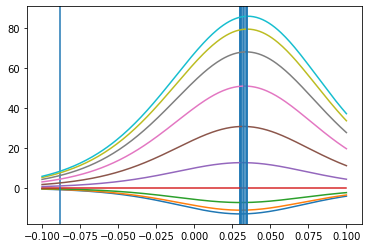

0.0021544346900318843


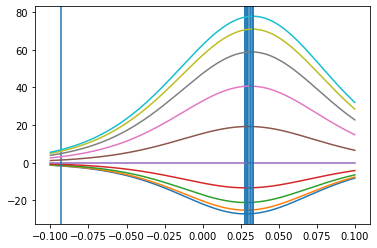

0.004641588833612777


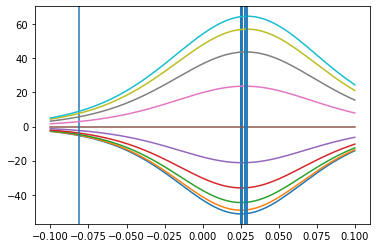

0.01


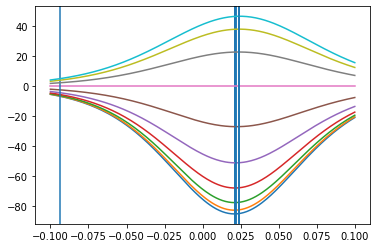

0.021544346900318832


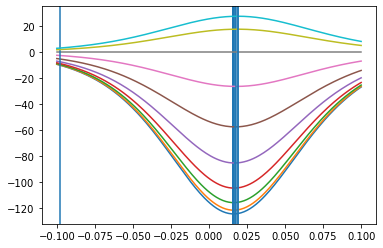

0.046415888336127774


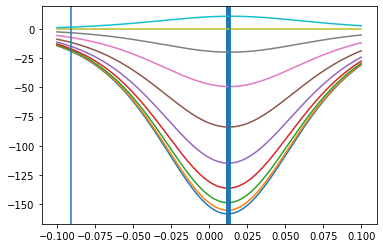

0.1


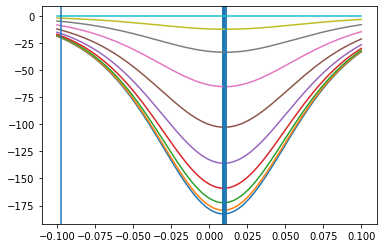

0.21544346900318823


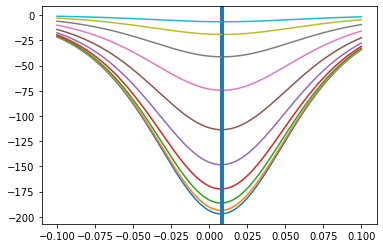

0.46415888336127775


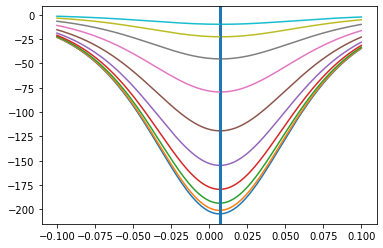

1.0


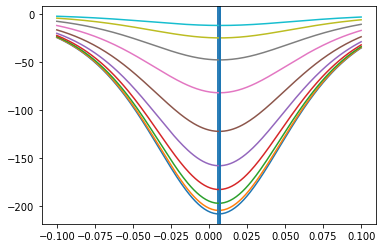

In [88]:
for na in da.na_in:
    print(na.values)
    for na_out_val in da.na_out:
        line_data = da.sel(c_h_in=1e-8, c_h_out=1e-7, charge=1, na_in=na, na_out=na_out_val)
        max_idx = abs(line_data).argmax()
        val = abs(da.sel(c_h_in=1e-8, c_h_out=1e-7, charge=1, na_in=na)).argmax(dim='voltages').values
        plt.plot(da.voltages, line_data)
        plt.axvline(da.voltages[max_idx])
        #for maximum in abs(da.sel(c_h_in=1e-8, c_h_out=1e-7, charge=1, na_in=na)).argmax(dim='voltages').values:
        #    plt.axvline(da.voltages[maximum])
    plt.show()

7.0 8.0 0.01 0.021544346900318832


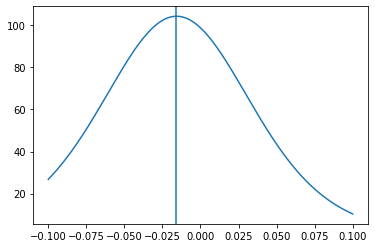

7.2 7.8 0.01 0.021544346900318832


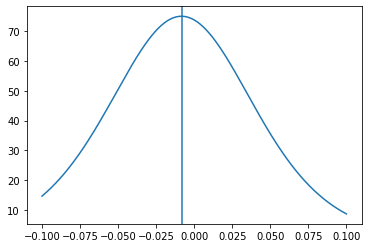

7.4 7.6 0.01 0.021544346900318832


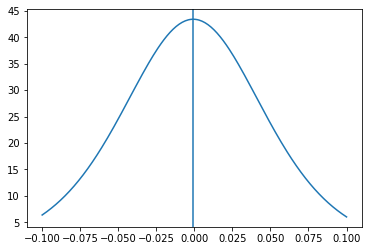

7.6 7.4 0.01 0.021544346900318832


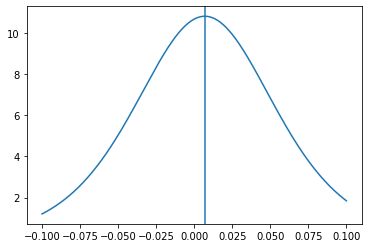

7.8 7.2 0.01 0.021544346900318832


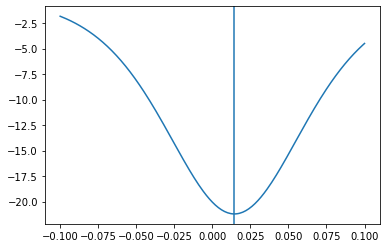

8.0 7.0 0.01 0.021544346900318832


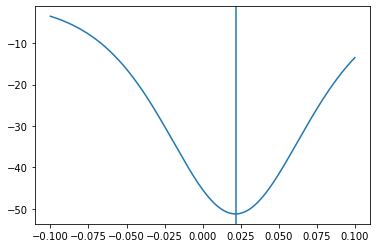

In [86]:
points = zip(da.c_h_in.values[::], da.c_h_out.values[::-1])

na_in_val = 0.010
na_out_val = da.na_out[4].values

for _in, _out in points:
    print(-np.log10(_in), -np.log10(_out), na_in_val, na_out_val)
    line_data = da.sel(c_h_in=_in, c_h_out=_out, charge=1, na_in=na_in_val, na_out=na_out_val)
    max_idx = abs(line_data).argmax()
    val = abs(da.sel(c_h_in=_in, c_h_out=_out, charge=1, na_in=na_in_val, na_out=na_out_val)).argmax(dim='voltages').values
    plt.plot(da.voltages, line_data)
    plt.axvline(da.voltages[max_idx])
        #for maximum in abs(da.sel(c_h_in=1e-8, c_h_out=1e-7, charge=1, na_in=na)).argmax(dim='voltages').values:
        #    plt.axvline(da.voltages[maximum])
    plt.show()

In [82]:
[(i,j) for i,j in enumerate(da.na_out.values)]

[(0, 0.001),
 (1, 0.0021544346900318843),
 (2, 0.004641588833612777),
 (3, 0.01),
 (4, 0.021544346900318832),
 (5, 0.046415888336127774),
 (6, 0.1),
 (7, 0.21544346900318823),
 (8, 0.46415888336127775),
 (9, 1.0)]